In [2]:
import sys
!{sys.executable} -m pip install itk vtk itkwidgets


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [1]:
import itk
import vtk
import numpy as np

import matplotlib.pyplot as plt

In [14]:
def load_nrrd_image(file_path):
    image = itk.imread(file_path)
    return image

def display_image_plt(image, im_number = 0, title="Image"):
    array = itk.GetArrayViewFromImage(image)
    print("array shape: ", array.shape)
    plt.figure()
    plt.title(title)
    plt.scatter([140], [80], color='red', s=100)
    plt.imshow(array[im_number])
    plt.show()


In [7]:
# Load the two images
image1 = load_nrrd_image('../Data/case6_gre1.nrrd')
image2 = load_nrrd_image('../Data/case6_gre2.nrrd')

In [8]:
image2.shape

(176, 256, 256)

array shape:  (176, 256, 256)


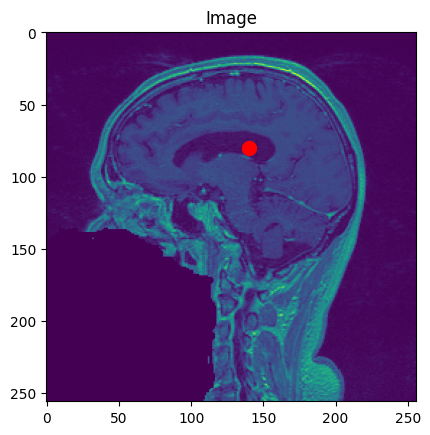

In [15]:
display_image_plt(image1, 100)

array shape:  (176, 256, 256)


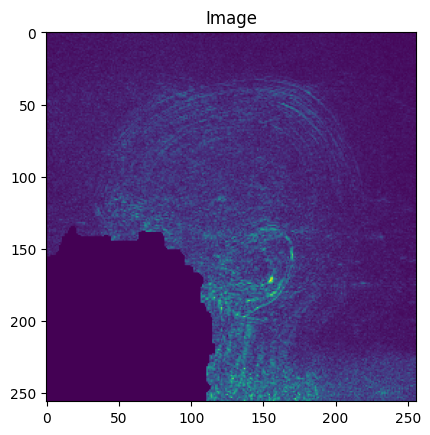

In [8]:
display_image_plt(image2, 2)

In [9]:
import itk

def register_images_translation(fixed_image_path, moving_image_path):
    PixelType = itk.ctype("float")
    
    fixedImage = itk.imread(fixed_image_path, PixelType)
    movingImage = itk.imread(moving_image_path, PixelType)

    Dimension = fixedImage.GetImageDimension()
    FixedImageType = itk.Image[PixelType, Dimension]
    MovingImageType = itk.Image[PixelType, Dimension]

    TransformType = itk.TranslationTransform[itk.D, Dimension]
    initialTransform = TransformType.New()

    optimizer = itk.RegularStepGradientDescentOptimizerv4.New(
        LearningRate=4,
        MinimumStepLength=0.001,
        RelaxationFactor=0.5,
        NumberOfIterations=200,
    )

    metric = itk.MeanSquaresImageToImageMetricv4[FixedImageType, MovingImageType].New()

    registration = itk.ImageRegistrationMethodv4[FixedImageType, MovingImageType].New(
        FixedImage=fixedImage,
        MovingImage=movingImage,
        Metric=metric,
        Optimizer=optimizer,
        InitialTransform=initialTransform,
    )

    movingInitialTransform = TransformType.New()
    initialParameters = movingInitialTransform.GetParameters()
    initialParameters[0] = 0
    initialParameters[1] = 0
    movingInitialTransform.SetParameters(initialParameters)
    registration.SetMovingInitialTransform(movingInitialTransform)

    identityTransform = TransformType.New()
    identityTransform.SetIdentity()
    registration.SetFixedInitialTransform(identityTransform)

    registration.SetNumberOfLevels(1)
    registration.SetSmoothingSigmasPerLevel([0])
    registration.SetShrinkFactorsPerLevel([1])

    registration.Update()

    transform = registration.GetTransform()
    finalParameters = transform.GetParameters()
    translationAlongX = finalParameters.GetElement(0)
    translationAlongY = finalParameters.GetElement(1)

    numberOfIterations = optimizer.GetCurrentIteration()

    bestValue = optimizer.GetValue()

    print("Result = ")
    print(" Translation X = " + str(translationAlongX))
    print(" Translation Y = " + str(translationAlongY))
    print(" Iterations    = " + str(numberOfIterations))
    print(" Metric value  = " + str(bestValue))

    CompositeTransformType = itk.CompositeTransform[itk.D, Dimension]
    outputCompositeTransform = CompositeTransformType.New()
    outputCompositeTransform.AddTransform(movingInitialTransform)
    outputCompositeTransform.AddTransform(registration.GetModifiableTransform())

    resampler = itk.ResampleImageFilter[MovingImageType, FixedImageType].New(
        Input=movingImage,
        Transform=outputCompositeTransform,
        UseReferenceImage=True,
        ReferenceImage=fixedImage,
    )
    resampler.SetDefaultPixelValue(100)

    resampler.Update()
    registered_image = resampler.GetOutput()

    return fixedImage, registered_image


In [10]:
fixed_image, registered_image = register_images_translation('../Data/case6_gre1.nrrd', '../Data/case6_gre2.nrrd')

Result = 
 Translation X = -0.8358830448193824
 Translation Y = -3.540664355686149
 Iterations    = 31
 Metric value  = 11177.923755087158


In [11]:
registered_image.shape, fixed_image.shape

((176, 256, 256), (176, 256, 256))

In [12]:
def display_mutiliples_plt(images, titles=None, im_number = 0):
    if titles is None:
        titles = ["Image"] * len(images)
    elif len(titles) != len(images):
        raise ValueError("The number of titles must match the number of images.")

    num_images = len(images)
    
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
    
    if num_images == 1:
        axs = [axs]
    
    for idx, (image, title) in enumerate(zip(images, titles)):
        array = itk.GetArrayViewFromImage(image)
        print(f"array shape for image {idx}: ", array.shape)
        axs[idx].imshow(array[im_number])
        axs[idx].set_title(title)
        axs[idx].axis('off')  # Hide axes
    
    plt.tight_layout()
    plt.show()

array shape for image 0:  (176, 256, 256)
array shape for image 1:  (176, 256, 256)
array shape for image 2:  (176, 256, 256)
array shape for image 3:  (176, 256, 256)


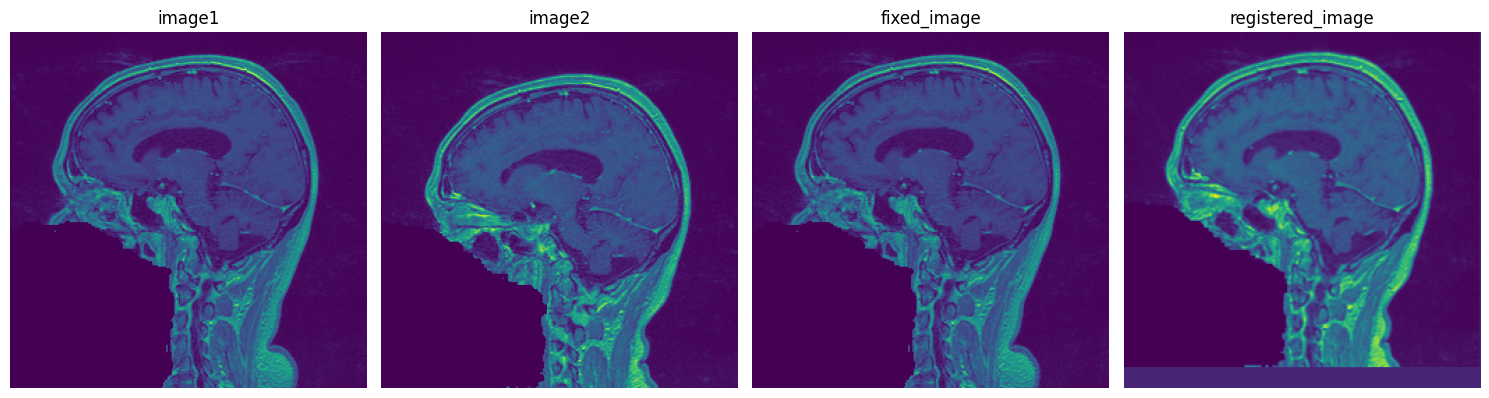

In [13]:
images = [image1, image2, fixed_image,registered_image]
titles = ["image1","image2" ,"fixed_image", "registered_image"]
display_mutiliples_plt(images, titles, 100)

In [14]:
import itk
import numpy as np

def rigid2D(fixed_image, moving_image):
    # Ensure images are 2D
    if fixed_image.GetImageDimension() != 2 or moving_image.GetImageDimension() != 2:
        raise ValueError("Both images must be 2D.")

    dimension = fixed_image.GetImageDimension()
    FixedImageType = type(fixed_image)
    MovingImageType = type(moving_image)

    TransformType = itk.Rigid2DTransform[itk.D]
    initialTransform = TransformType.New()

    optimizer = itk.RegularStepGradientDescentOptimizerv4.New()

    optimizer.SetLearningRate(4)
    optimizer.SetMinimumStepLength(0.001)
    optimizer.SetNumberOfIterations(200)

    metric = itk.MeanSquaresImageToImageMetricv4[FixedImageType, MovingImageType].New()

    registration = itk.ImageRegistrationMethodv4.New(FixedImage=fixed_image, MovingImage=moving_image, Metric=metric,
                                                     Optimizer=optimizer, InitialTransform=initialTransform)

    moving_initial_transform = TransformType.New()
    initial_parameters = moving_initial_transform.GetParameters()
    initial_parameters[0] = 0
    initial_parameters[1] = 0
    initial_parameters[2] = 0
    moving_initial_transform.SetParameters(initial_parameters)

    # Set the scales
    scale_parameters = moving_initial_transform.GetParameters()
    scale_parameters[0] = 1000
    scale_parameters[1] = 1
    scale_parameters[2] = 1
    optimizer.SetScales(scale_parameters)

    registration.SetMovingInitialTransform(moving_initial_transform)

    # Set the center of the image
    fixed_parameters = moving_initial_transform.GetFixedParameters()
    fixed_parameters[0] = moving_image.GetLargestPossibleRegion().GetSize()[0] / 2.0
    fixed_parameters[1] = moving_image.GetLargestPossibleRegion().GetSize()[1] / 2.0

    moving_initial_transform.SetFixedParameters(fixed_parameters)

    identity_transform = TransformType.New()
    identity_transform.SetIdentity()
    registration.SetFixedInitialTransform(identity_transform)
    registration.SetNumberOfLevels(1)

    registration.Update()

    transform = registration.GetTransform()
    final_parameters = transform.GetParameters()
    angle = final_parameters.GetElement(0)
    translation_along_x = final_parameters.GetElement(1)
    translation_along_y = final_parameters.GetElement(2)

    number_of_iterations = optimizer.GetCurrentIteration()

    best_value = optimizer.GetValue()

    print("Result = ")
    print(" Angle = " + str(angle))
    print(" Translation X = " + str(translation_along_x))
    print(" Translation Y = " + str(translation_along_y))
    print(" Iterations    = " + str(number_of_iterations))
    print(" Metric value  = " + str(best_value))

    CompositeTransformType = itk.CompositeTransform[itk.D, dimension]
    output_composite_transform = CompositeTransformType.New()
    output_composite_transform.AddTransform(moving_initial_transform)
    output_composite_transform.AddTransform(registration.GetModifiableTransform())

    resampler = itk.ResampleImageFilter.New(Input=moving_image, Transform=transform, UseReferenceImage=True,
                                            ReferenceImage=fixed_image)
    resampler.SetDefaultPixelValue(100)
    resampler.Update()
    registered_image = resampler.GetOutput()

    return registered_image


In [15]:
def rigid_info_mutuelle(fixed_image,
         moving_image):
    # Ensure images are 2D
    if fixed_image.GetImageDimension() != 2 or moving_image.GetImageDimension() != 2:
        raise ValueError("Both images must be 2D.")
    dimension = fixed_image.GetImageDimension()
    FixedImageType = type(fixed_image)
    MovingImageType = type(moving_image)

    TransformType = itk.Rigid2DTransform[itk.D]
    initialTransform = TransformType.New()

    optimizer = itk.RegularStepGradientDescentOptimizerv4.New()

    optimizer.SetLearningRate(4)
    optimizer.SetMinimumStepLength(0.001)
    optimizer.SetNumberOfIterations(200)

    metric = itk.MattesMutualInformationImageToImageMetricv4[FixedImageType, MovingImageType].New()

    registration = itk.ImageRegistrationMethodv4.New(FixedImage=fixed_image, MovingImage=moving_image, Metric=metric,
                                                     Optimizer=optimizer, InitialTransform=initialTransform, )

    moving_initial_transform = TransformType.New()
    initial_parameters = moving_initial_transform.GetParameters()
    initial_parameters[0] = 0
    initial_parameters[1] = 0
    initial_parameters[2] = 0
    moving_initial_transform.SetParameters(initial_parameters)

    # Set the scales
    scale_parameters = moving_initial_transform.GetParameters()
    scale_parameters[0] = 1000
    scale_parameters[1] = 1
    scale_parameters[2] = 1
    optimizer.SetScales(scale_parameters)

    registration.SetMovingInitialTransform(moving_initial_transform)

    # Set the center of the image
    fixed_parameters = moving_initial_transform.GetFixedParameters()
    fixed_parameters[0] = moving_image.GetLargestPossibleRegion().GetSize()[0] / 2.0
    fixed_parameters[1] = moving_image.GetLargestPossibleRegion().GetSize()[1] / 2.0

    moving_initial_transform.SetFixedParameters(fixed_parameters)

    identity_transform = TransformType.New()
    identity_transform.SetIdentity()
    registration.SetFixedInitialTransform(identity_transform)
    registration.SetNumberOfLevels(1)

    registration.Update()

    transform = registration.GetTransform()
    final_parameters = transform.GetParameters()
    angle = final_parameters.GetElement(0)
    translation_along_x = final_parameters.GetElement(1)
    translation_along_y = final_parameters.GetElement(2)

    number_of_iterations = optimizer.GetCurrentIteration()

    best_value = optimizer.GetValue()

    print("Result = ")
    print(" Angle = " + str(angle))
    print(" Translation X = " + str(translation_along_x))
    print(" Translation Y = " + str(translation_along_y))
    print(" Iterations    = " + str(number_of_iterations))
    print(" Metric value  = " + str(best_value))

    CompositeTransformType = itk.CompositeTransform[itk.D, dimension]
    output_composite_transform = CompositeTransformType.New()
    output_composite_transform.AddTransform(moving_initial_transform)
    output_composite_transform.AddTransform(registration.GetModifiableTransform())

    resampler = itk.ResampleImageFilter.New(Input=moving_image, Transform=transform, UseReferenceImage=True,
                                            ReferenceImage=fixed_image, )
    resampler.SetDefaultPixelValue(100)
    resampler.Update()

    registered_image = resampler.GetOutput()

    return registered_image

In [16]:
def affine2D(fixed_image, moving_image):
    # Ensure images are 2D
    if fixed_image.GetImageDimension() != 2 or moving_image.GetImageDimension() != 2:
        raise ValueError("Both images must be 2D.")

    FixedImageType = type(fixed_image)
    MovingImageType = type(moving_image)

    TransformType = itk.AffineTransform[itk.D, 2]
    initialTransform = TransformType.New()

    optimizer = itk.RegularStepGradientDescentOptimizerv4.New(
        LearningRate=4,
        MinimumStepLength=0.001,
        NumberOfIterations=200
    )

    metric = itk.MeanSquaresImageToImageMetricv4[FixedImageType, MovingImageType].New()

    registration = itk.ImageRegistrationMethodv4[FixedImageType, MovingImageType].New(
        FixedImage=fixed_image,
        MovingImage=moving_image,
        Metric=metric,
        Optimizer=optimizer,
        InitialTransform=initialTransform
    )

    moving_initial_transform = TransformType.New()
    initial_parameters = moving_initial_transform.GetParameters()
    initial_parameters.Fill(0)
    moving_initial_transform.SetParameters(initial_parameters)

    scale_parameters = moving_initial_transform.GetParameters()
    scale_parameters.Fill(1)
    optimizer.SetScales(scale_parameters)

    registration.SetMovingInitialTransform(moving_initial_transform)

    fixed_parameters = moving_initial_transform.GetFixedParameters()
    fixed_parameters.Fill(fixed_image.GetLargestPossibleRegion().GetSize()[0] / 2.0)
    moving_initial_transform.SetFixedParameters(fixed_parameters)

    identity_transform = TransformType.New()
    identity_transform.SetIdentity()
    registration.SetFixedInitialTransform(identity_transform)
    registration.SetNumberOfLevels(1)

    registration.Update()

    transform = registration.GetTransform()
    final_parameters = transform.GetParameters()

    # Convert final_parameters to numpy array
    final_parameters_array = np.array(final_parameters)

    # Extract affine matrix and translation vector
    matrix = np.array(final_parameters_array[:6]).reshape(2, 3)  # 2x3 matrix
    translation = np.array(final_parameters_array[6:8])  # Translation vector

    number_of_iterations = optimizer.GetCurrentIteration()
    best_value = optimizer.GetValue()

    print("Result = ")
    print(" Affine Matrix = ")
    print(matrix)
    print(" Translation = " + str(translation))
    print(" Iterations    = " + str(number_of_iterations))
    print(" Metric value  = " + str(best_value))

    CompositeTransformType = itk.CompositeTransform[itk.D, 2]
    output_composite_transform = CompositeTransformType.New()
    output_composite_transform.AddTransform(moving_initial_transform)
    output_composite_transform.AddTransform(registration.GetModifiableTransform())

    resampler = itk.ResampleImageFilter[MovingImageType, FixedImageType].New(
        Input=moving_image,
        Transform=output_composite_transform,
        UseReferenceImage=True,
        ReferenceImage=fixed_image
    )
    resampler.SetDefaultPixelValue(100)
    resampler.Update()
    registered_image = resampler.GetOutput()

    return registered_image

def register_images_type(fixed_image_path, moving_image_path, type="rigid"):
    PixelType = itk.ctype("float")

    fixedImage = itk.imread(fixed_image_path, PixelType)
    movingImage = itk.imread(moving_image_path, PixelType)

    # Ensure the images are 3D
    if fixedImage.GetImageDimension() != 3 or movingImage.GetImageDimension() != 3:
        raise ValueError("Both images must be 3D.")

    # Extract slices
    fixed_slices = [itk.GetImageFromArray(itk.GetArrayViewFromImage(fixedImage)[i, :, :]) for i in range(fixedImage.GetLargestPossibleRegion().GetSize()[2])]
    moving_slices = [itk.GetImageFromArray(itk.GetArrayViewFromImage(movingImage)[i, :, :]) for i in range(movingImage.GetLargestPossibleRegion().GetSize()[2])]

    # Check if number of slices matches
    if len(fixed_slices) != len(moving_slices):
        raise ValueError("The number of slices in both images must match.")

    # Apply transformation to each slice
    registered_slices = []
    for i in range(len(fixed_slices)):
        if type == "rigid":
            registered_slice = rigid2D(fixed_slices[i], moving_slices[i])
        elif type == "affine":
            registered_slice = affine2D(fixed_slices[i], moving_slices[i])
        elif type == "info_mutuelle":
            registered_slice = rigid_info_mutuelle(fixed_slices[i], moving_slices[i])
        else:
            raise ValueError("Unknown transformation type. Use 'rigid', 'affine'")
        registered_slices.append(itk.GetArrayViewFromImage(registered_slice))

    # Stack the registered slices to form a 3D image
    registered_image_array = np.stack(registered_slices, axis=0)
    registered_image_3d = itk.GetImageFromArray(registered_image_array)
    registered_image_3d.SetSpacing(fixedImage.GetSpacing())
    registered_image_3d.SetOrigin(fixedImage.GetOrigin())
    registered_image_3d.SetDirection(fixedImage.GetDirection())

    return fixedImage, registered_image_3d


In [17]:
fixed_image, registered_image_info_mutuelle = register_images_type('../Data/case6_gre1.nrrd', '../Data/case6_gre2.nrrd', type='info_mutuelle')

Result = 
 Angle = 0.04951392650007726
 Translation X = 1.4766918938556315
 Translation Y = 13.50070890219528
 Iterations    = 54
 Metric value  = -0.8950819302019404
Result = 
 Angle = 0.030933935436886998
 Translation X = -0.09386410700415977
 Translation Y = 13.783744173339024
 Iterations    = 76
 Metric value  = -0.9216202765539384
Result = 
 Angle = 0.05792365097192785
 Translation X = 3.70805640952729
 Translation Y = 13.641701408201845
 Iterations    = 42
 Metric value  = -0.8702650230795551
Result = 
 Angle = 0.07547873583307795
 Translation X = 5.681887250373925
 Translation Y = 13.265300222970833
 Iterations    = 64
 Metric value  = -0.7866523843910552
Result = 
 Angle = 0.09383595633328339
 Translation X = 6.757518238686993
 Translation Y = 13.705012762011734
 Iterations    = 33
 Metric value  = -0.6561463526676486
Result = 
 Angle = 0.09347402386496155
 Translation X = 6.8117132682933645
 Translation Y = 14.30122417464854
 Iterations    = 29
 Metric value  = -0.581178880107

In [18]:
# Example usage
fixed_image, registered_image_rigid = register_images_type('../Data/case6_gre1.nrrd', '../Data/case6_gre2.nrrd', type='rigid')

fixed_image, registered_image_affine = register_images_type('../Data/case6_gre1.nrrd', '../Data/case6_gre2.nrrd', type='affine')

Result = 
 Angle = 0.05262512018512745
 Translation X = 0.262698377870009
 Translation Y = 8.748847057933569
 Iterations    = 71
 Metric value  = 61.26644187303076
Result = 
 Angle = 0.040574407164622926
 Translation X = 0.4985915314097176
 Translation Y = 10.523113665217672
 Iterations    = 71
 Metric value  = 50.923194379451104
Result = 
 Angle = 0.048508025095195716
 Translation X = 1.6011501116803122
 Translation Y = 11.611346144614366
 Iterations    = 77
 Metric value  = 54.605165106542934
Result = 
 Angle = 0.09026196713153878
 Translation X = 6.515516630441084
 Translation Y = 13.384303243945368
 Iterations    = 50
 Metric value  = 60.40752914279035
Result = 
 Angle = 0.08877957266169835
 Translation X = 7.144218707946932
 Translation Y = 14.634432919977
 Iterations    = 31
 Metric value  = 92.4029934896157
Result = 
 Angle = 0.03839689810933514
 Translation X = 6.64577084743572
 Translation Y = 15.77121054627995
 Iterations    = 60
 Metric value  = 145.12864978006021
Result = 


array shape for image 0:  (176, 256, 256)
array shape for image 1:  (176, 256, 256)
array shape for image 2:  (176, 256, 256)
array shape for image 3:  (176, 256, 256)
array shape for image 4:  (176, 256, 256)
array shape for image 5:  (176, 256, 256)


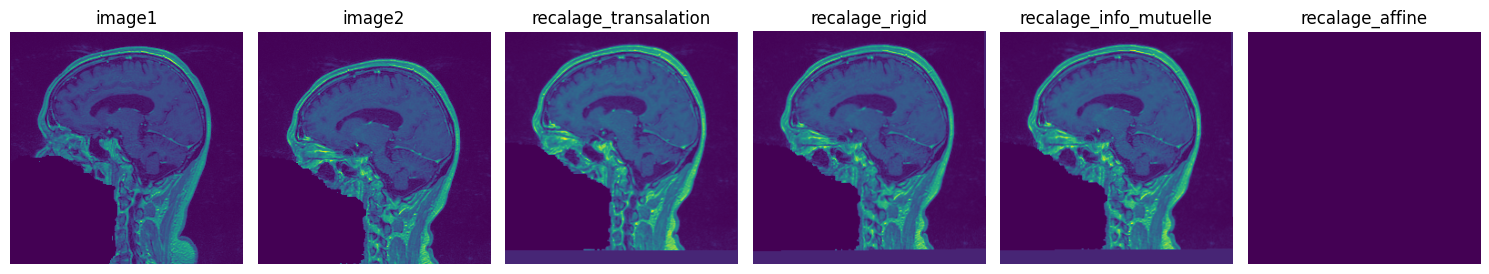

In [19]:
images = [image1, image2,registered_image]
titles = ["image1","image2" , "recalage_transalation"]

images.append(registered_image_rigid)
titles.append("recalage_rigid")
images.append(registered_image_info_mutuelle)
titles.append("recalage_info_mutuelle")
images.append(registered_image_affine)
titles.append("recalage_affine")
display_mutiliples_plt(images, titles, 100)

In [20]:
def segment_tumor(image, lower_threshold=50, upper_threshold=150):
    PixelType = itk.template(image)[1][0]
    Dimension = image.GetImageDimension()
    ImageType = itk.Image[PixelType, Dimension]

    threshold_filter = itk.BinaryThresholdImageFilter[ImageType, ImageType].New()
    threshold_filter.SetInput(image)
    threshold_filter.SetLowerThreshold(lower_threshold)
    threshold_filter.SetUpperThreshold(upper_threshold)
    threshold_filter.SetInsideValue(1)
    threshold_filter.SetOutsideValue(0)

    threshold_filter.Update()
    segmented_image = threshold_filter.GetOutput()

    return segmented_image

In [21]:
fixed_tumor = segment_tumor(fixed_image)
moving_tumor = segment_tumor(registered_image_info_mutuelle)

In [22]:
fixed_tumor.shape, moving_tumor.shape

((176, 256, 256), (176, 256, 256))

array shape for image 0:  (176, 256, 256)
array shape for image 1:  (176, 256, 256)


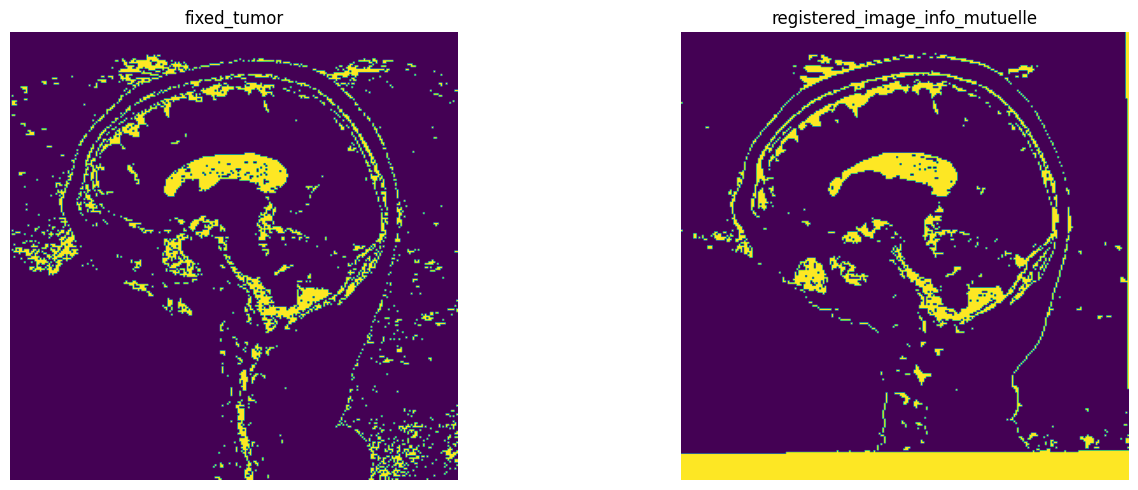

In [23]:
images = [fixed_tumor, moving_tumor]
titles = ["fixed_tumor","registered_image_info_mutuelle" ]
display_mutiliples_plt(images, titles, 100)

In [24]:
def segment_tumor_2d(slice_2d, seedX=110, seedY=100, lower=180, upper=255):
    # Ensure the slice is of type itk.Image
    if not isinstance(slice_2d, itk.Image):
        raise ValueError("The slice must be of type itk.Image.")
    
    # Smooth the slice
    smoother = itk.GradientAnisotropicDiffusionImageFilter.New(Input=slice_2d, NumberOfIterations=20, TimeStep=0.04,
                                                               ConductanceParameter=3)
    smoother.Update()

    connected_threshold = itk.ConnectedThresholdImageFilter.New(Input=smoother.GetOutput())
    connected_threshold.SetReplaceValue(255)
    connected_threshold.SetLower(lower)
    connected_threshold.SetUpper(upper)

    # Setting the seed as an itk.Index
    seed = itk.Index[2]()
    seed.SetElement(0, seedX)
    seed.SetElement(1, seedY)
    connected_threshold.AddSeed(seed)

    connected_threshold.Update()

    in_type = type(connected_threshold.GetOutput())
    output_type = itk.Image[itk.UC, 2]
    rescaler = itk.RescaleIntensityImageFilter[in_type, output_type].New(Input=connected_threshold.GetOutput())
    rescaler.SetOutputMinimum(0)
    rescaler.SetOutputMaximum(255)
    rescaler.Update()
    
    return rescaler.GetOutput()

def segment_tumor_v2(input_image, seedX=110, seedY=100, lower=180, upper=255):
    dimension = input_image.GetImageDimension()
    if dimension != 3:
        raise ValueError("The input image must be 3D.")

    size = input_image.GetLargestPossibleRegion().GetSize()

    # Extract slices
    slices = [itk.GetImageFromArray(itk.GetArrayViewFromImage(input_image)[i, :, :]) for i in range(size[2])]

    # Apply segmentation to each slice
    segmented_slices = []
    for slice_2d in slices:
        segmented_slice = segment_tumor_2d(slice_2d, seedX, seedY, lower, upper)
        segmented_slices.append(itk.GetArrayViewFromImage(segmented_slice))

    # Stack the segmented slices to form a 3D image
    segmented_image_array = np.stack(segmented_slices, axis=0)
    segmented_image_3d = itk.GetImageFromArray(segmented_image_array)
    segmented_image_3d.SetSpacing(input_image.GetSpacing())
    segmented_image_3d.SetOrigin(input_image.GetOrigin())
    segmented_image_3d.SetDirection(input_image.GetDirection())

    return segmented_image_3d

In [25]:
fixed_image.shape

(176, 256, 256)

In [26]:
fixed_tumor = segment_tumor_v2(fixed_image, seedX=150, seedY=150, lower=0, upper=255)
moving_tumor = segment_tumor_v2(registered_image_info_mutuelle,seedX=150, seedY=150, lower=0, upper=255)

In [27]:
images = [fixed_tumor, moving_tumor]
titles = ["fixed_tumor","registered_image_info_mutuelle" ]

array shape for image 0:  (176, 256, 256)
array shape for image 1:  (176, 256, 256)


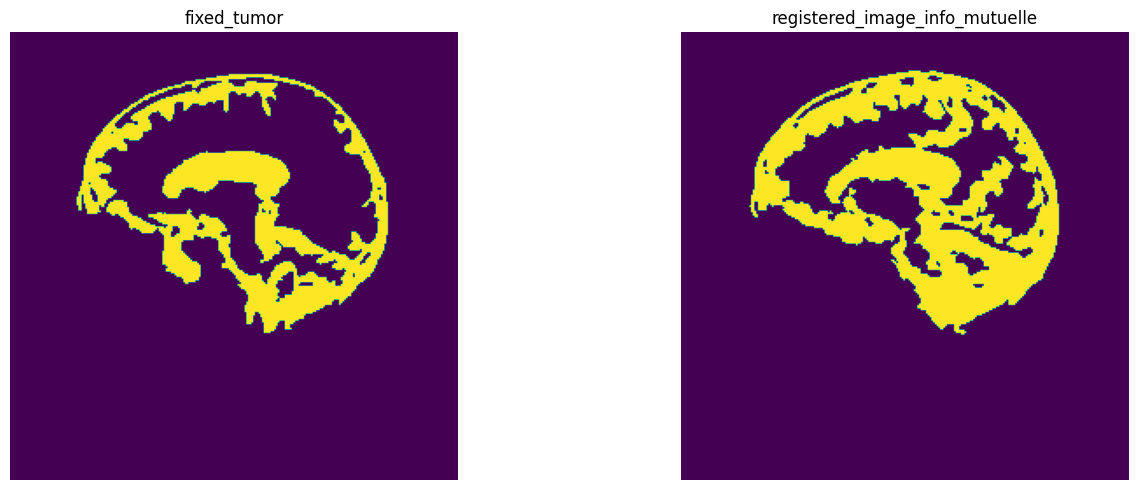

In [28]:
display_mutiliples_plt(images, titles, 100)

In [29]:
def calculate_volume(segmented_image):
    array = itk.GetArrayViewFromImage(segmented_image)
    volume = np.sum(array > 0)  # Count the number of non-zero voxels
    return volume

fixed_volume = calculate_volume(fixed_tumor)
moving_volume = calculate_volume(moving_tumor)

print(f"Fixed tumor volume: {fixed_volume} voxels")
print(f"Moving tumor volume: {moving_volume} voxels")

Fixed tumor volume: 1905675 voxels
Moving tumor volume: 3550953 voxels


In [30]:
def calculate_intensity_difference(fixed_tumor, moving_tumor):
    fixed_array = itk.GetArrayViewFromImage(fixed_tumor)
    moving_array = itk.GetArrayViewFromImage(moving_tumor)

    # Calculate absolute difference
    difference = np.abs(fixed_array - moving_array)

    return difference

intensity_difference = calculate_intensity_difference(fixed_tumor, moving_tumor)

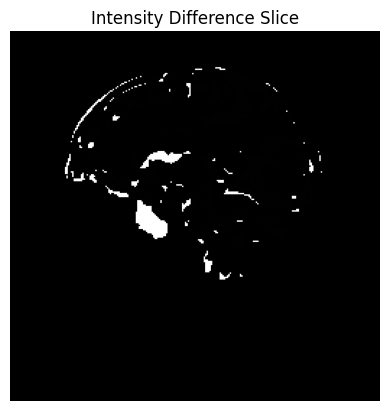

In [31]:
def display_slice(image, slice_index, title="Slice"):
    array = itk.GetArrayViewFromImage(image)[slice_index, :, :]
    plt.imshow(array, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()
display_slice(itk.GetImageFromArray(intensity_difference), 100, title="Intensity Difference Slice")


In [35]:
def visualize_slices(image):
    # Convert ITK image to VTK image
    vtk_image = itk.vtk_image_from_image(image)

    # Setup the rendering environment
    renderer = vtk.vtkRenderer()
    render_window = vtk.vtkRenderWindow()
    render_window.AddRenderer(renderer)
    render_window_interactor = vtk.vtkRenderWindowInteractor()
    render_window_interactor.SetRenderWindow(render_window)

    # Extract the dimensions of the image
    dims = vtk_image.GetDimensions()

    # Create a slider to navigate through slices
    slider_rep = vtk.vtkSliderRepresentation2D()
    slider_rep.SetMinimumValue(0)
    slider_rep.SetMaximumValue(dims[2] - 1)
    slider_rep.SetValue(0)
    slider_rep.SetTitleText("Slice")
    slider_rep.GetSliderProperty().SetColor(1, 0, 0)
    slider_rep.GetTitleProperty().SetColor(1, 0, 0)
    slider_rep.GetLabelProperty().SetColor(1, 0, 0)
    slider_rep.GetSelectedProperty().SetColor(0, 1, 0)
    slider_rep.GetTubeProperty().SetColor(1, 1, 0)
    slider_rep.GetCapProperty().SetColor(1, 1, 0)
    slider_rep.SetSliderLength(0.02)
    slider_rep.SetSliderWidth(0.03)
    slider_rep.SetEndCapLength(0.01)
    slider_rep.SetEndCapWidth(0.03)
    slider_rep.SetTubeWidth(0.005)
    slider_rep.SetLabelFormat("%3.0lf")
    slider_rep.GetPoint1Coordinate().SetCoordinateSystemToNormalizedDisplay()
    slider_rep.GetPoint1Coordinate().SetValue(0.1, 0.1)
    slider_rep.GetPoint2Coordinate().SetCoordinateSystemToNormalizedDisplay()
    slider_rep.GetPoint2Coordinate().SetValue(0.9, 0.1)

    slider_widget = vtk.vtkSliderWidget()
    slider_widget.SetInteractor(render_window_interactor)
    slider_widget.SetRepresentation(slider_rep)
    slider_widget.SetAnimationModeToAnimate()

    # Create an image viewer
    image_viewer = vtk.vtkImageViewer2()
    image_viewer.SetInputData(vtk_image)
    image_viewer.SetSlice(0)
    image_viewer.SetRenderer(renderer)
    image_viewer.SetRenderWindow(render_window)

    # Center the image
    renderer.GetActiveCamera().ParallelProjectionOn()
    image_center = [dims[0] // 2, dims[1] // 2, 0]
    renderer.GetActiveCamera().SetFocalPoint(image_center)
    renderer.GetActiveCamera().SetPosition(image_center[0], image_center[1], -dims[2])
    renderer.ResetCamera()

    def update_slice(obj, event):
        slider_value = int(slider_rep.GetValue())
        image_viewer.SetSlice(slider_value)
        render_window.Render()

    slider_widget.AddObserver("InteractionEvent", update_slice)

    # Initialize and start the interaction
    slider_widget.EnabledOn()
    image_viewer.Render()
    render_window_interactor.Start()
visualize_slices(itk.GetImageFromArray(intensity_difference))

In [5]:
def visualize_contours(fixed_tumor):
    def create_contour_actor(image, value, color):
        # Convert ITK image to VTK image
        vtk_image = itk.vtk_image_from_image(image)

        # Generate contours
        contour_filter = vtk.vtkContourFilter()
        contour_filter.SetInputData(vtk_image)
        contour_filter.SetValue(0, value)  # Assuming the tumor is segmented with the provided value
        contour_filter.Update()

        # Create mapper
        contour_mapper = vtk.vtkPolyDataMapper()
        contour_mapper.SetInputConnection(contour_filter.GetOutputPort())
        contour_mapper.ScalarVisibilityOff()

        # Create actor
        contour_actor = vtk.vtkActor()
        contour_actor.SetMapper(contour_mapper)
        contour_actor.GetProperty().SetColor(color)  # Set color of the actor

        return contour_actor

    # Setup rendering
    renderer = vtk.vtkRenderer()
    render_window = vtk.vtkRenderWindow()
    render_window.AddRenderer(renderer)
    render_window_interactor = vtk.vtkRenderWindowInteractor()
    render_window_interactor.SetRenderWindow(render_window)

    # Create and add contour actors for both fixed and moving tumors
    fixed_actor = create_contour_actor(fixed_tumor, 255, (1.0, 0.0, 0.0))  # Red color for fixed tumor

    renderer.AddActor(fixed_actor)

    # Set the interactor style
    style = vtk.vtkInteractorStyleTrackballCamera()
    render_window_interactor.SetInteractorStyle(style)

    # Set background color and render
    renderer.SetBackground(0.1, 0.2, 0.4)
    render_window.Render()
    render_window_interactor.Start()
visualize_contours(image1)